## 1. Read in the data and transform latitude and longitude to x-y coordinate

In [1]:
import os
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy import nanmax,argmax, unravel_index
import scipy.stats as stat
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from datetime import timedelta,datetime 
from dateutil import tz
import time
from scipy.spatial.distance import pdist, squareform
np.set_printoptions(threshold=np.nan)

In [67]:
data = pd.DataFrame()
for info in os.listdir('C:/Users/glius/Google Drive/Gaussian Process/gps-iphonex/2019-04-0910'):
  domain = os.path.abspath(r'C:/Users/glius/Google Drive/Gaussian Process/gps-iphonex/2019-04-0910')
  info = os.path.join(domain,info)
  df = pd.read_csv(info)
  data = data.append(df)
data.shape

(12898, 6)

In [3]:
data.head(10)

,timestamp,UTC time,latitude,longitude,altitude,accuracy
0,1554783150961,2019-04-09T04:12:30.961,42.367318,-71.113643,10.099135,128.000000
1,1554783151968,2019-04-09T04:12:31.968,42.367204,-71.113840,12.710113,32.000000
2,1554783152973,2019-04-09T04:12:32.973,42.367204,-71.113840,12.710113,32.004833
3,1554783153974,2019-04-09T04:12:33.974,42.367204,-71.113840,12.710113,32.004833
4,1554783155062,2019-04-09T04:12:35.062,42.367204,-71.113840,12.710113,32.004833
5,1554783156061,2019-04-09T04:12:36.061,42.367204,-71.113840,12.710113,24.003625
6,1554783157063,2019-04-09T04:12:37.063,42.367204,-71.113840,12.710113,24.003625
7,1554783158062,2019-04-09T04:12:38.062,42.367204,-71.113840,12.710113,24.003625
8,1554783159062,2019-04-09T04:12:39.062,42.367204,-71.113840,12.710113,24.003625
9,1554783160059,2019-04-09T04:12:40.059,42.367204,-71.113840,12.710113,16.002417


In [4]:
UTC = [datetime.strptime(i, '%Y-%m-%dT%H:%M:%S.%f') for i in data['UTC time']]
EST = [UTC[i]-timedelta(hours=4) for i in range(data.shape[0])]
year = [EST[i].year for i in range(data.shape[0])]
month = [EST[i].month for i in range(data.shape[0])]
day = [EST[i].day for i in range(data.shape[0])]
hour = [EST[i].hour for i in range(data.shape[0])]
data['year'] = pd.Series(year)
data['month'] = pd.Series(month)
data['day'] = pd.Series(day)
data['hour'] = pd.Series(hour)
data.head(10)

,timestamp,UTC time,latitude,longitude,altitude,accuracy,year,month,day,hour
0,1554783150961,2019-04-09T04:12:30.961,42.367318,-71.113643,10.099135,128.000000,2019,4,9,0
1,1554783151968,2019-04-09T04:12:31.968,42.367204,-71.113840,12.710113,32.000000,2019,4,9,0
2,1554783152973,2019-04-09T04:12:32.973,42.367204,-71.113840,12.710113,32.004833,2019,4,9,0
3,1554783153974,2019-04-09T04:12:33.974,42.367204,-71.113840,12.710113,32.004833,2019,4,9,0
4,1554783155062,2019-04-09T04:12:35.062,42.367204,-71.113840,12.710113,32.004833,2019,4,9,0
5,1554783156061,2019-04-09T04:12:36.061,42.367204,-71.113840,12.710113,24.003625,2019,4,9,0
6,1554783157063,2019-04-09T04:12:37.063,42.367204,-71.113840,12.710113,24.003625,2019,4,9,0
7,1554783158062,2019-04-09T04:12:38.062,42.367204,-71.113840,12.710113,24.003625,2019,4,9,0
8,1554783159062,2019-04-09T04:12:39.062,42.367204,-71.113840,12.710113,24.003625,2019,4,9,0
9,1554783160059,2019-04-09T04:12:40.059,42.367204,-71.113840,12.710113,16.002417,2019,4,9,0


In [5]:
## change the unit of angles to pi
def xytransform(data):
  timestamp = np.array(data["timestamp"]-min(data["timestamp"]))/1000
  latitude = np.array(data["latitude"])/180*math.pi
  longitude = np.array(data["longitude"])/180*math.pi
  lam_min=min(latitude)
  lam_max=max(latitude)
  phi_min=min(longitude)
  phi_max=max(longitude)
  R=6.371*10**6
  d1=(lam_max-lam_min)*R
  d2=(phi_max-phi_min)*R*math.sin(math.pi/2-lam_max)
  d3=(phi_max-phi_min)*R*math.sin(math.pi/2-lam_min)
  w1=(latitude-lam_min)/(lam_max-lam_min)
  w2=(longitude-phi_min)/(phi_max-phi_min)
  x=np.array(w1*(d3-d2)/2+w2*(d3*(1-w1)+d2*w1))
  y=np.array(w1*d1*math.sin(math.acos((d3-d2)/(2*d1))))
  return {'t':timestamp,'x':x,'y':y,'year':np.array(data['year']),'month':np.array(data['month']),
          'day':np.array(data['day']),'hour':np.array(data['hour'])}

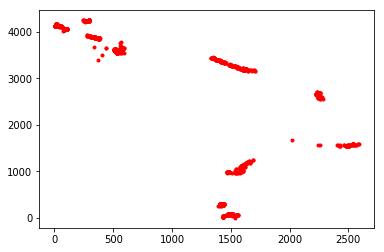

In [6]:
txy = xytransform(data)
plt.plot(txy['x'],txy['y'],'r.')
plt.show()

## 2. Define small functions used in SOGP function

In [7]:
## parameter 1: kernel K0
## x = [t,g], where t is timestamp in seconds and g is x/y in meters
## period: 1 day = 24*60*60 = 86400s 1 week = 86400s*7 = 604800s

a1 = 10
b1 = 10
a2 = 70
b2 = 70
g = 50

def K0(x1,x2):
  k1 = np.exp(-((abs(x1[0]-x2[0]))%86400)/a1)*np.exp(-np.floor(abs(x1[0]-x2[0])/86400)/b1)
  k2 = np.exp(-((abs(x1[0]-x2[0]))%604800)/a2)*np.exp(-np.floor(abs(x1[0]-x2[0])/604800)/b2)
  k3 = np.exp(-abs(x1[1]-x2[1])/200)
  return 0.35*k1+0.15*k2+0.5*k3

## similarity matrix between bv's
def update_K(bv,t,K,X):
  if t==0:
    mat = np.array([1])
  else:
    d = np.shape(K)[0]
    row = np.ones(d)
    column = np.ones([d+1,1])
    if X.ndim==1:
      for i in range(d):
        row[i] = column[i,0] = K0(X[t],X[bv[i]])
    else:
      for i in range(d):
        row[i] = column[i,0] = K0(X[t,:],X[bv[i],:])
    mat = np.hstack([np.vstack([K,row]),column])
  return mat

## similarity vector between the t'th input with all bv's, t starts from 0 here
def update_k(bv,t,X):
  d = len(bv) 
  if d==0:
    out = np.array([0])
  if d>=1:
    out = np.zeros(d)
    if X.ndim==1:
      for i in range(d):
        out[i] = K0(X[t],X[bv[i]])
    else:
      for i in range(d):
        out[i] = K0(X[t,:],X[bv[i],:])
  return out

def update_e_hat(Q,k):
  if np.shape(Q)[0]==0:
    out = np.array([0])
  else:
    out = np.dot(Q,k)
  return out

def update_gamma(k,e_hat):
  return 1-np.dot(k,e_hat)

def update_q(t,k,alpha,sigmax,Y):
  if t==0:
    out = Y[t]/sigmax
  else:
    out = (Y[t]-np.dot(k,alpha))/sigmax
  return out

def update_s_hat(C,k,e_hat):
  return np.dot(C,k)+e_hat

def update_eta(gamma,sigmax):
  r = -1/sigmax
  return 1/(1+gamma*r)

def update_alpha_hat(alpha,q,eta,s_hat):
  return alpha+q*eta*s_hat

def update_c_hat(C,sigmax,eta,s_hat):
  r = -1/sigmax
  return C+r*eta*np.outer(s_hat,s_hat)

def update_s(C,k):
  if np.shape(C)[0]==0:
    s = np.array([1])
  else:
    temp = np.dot(C,k)
    s = np.append(temp,1)
  return s

def update_alpha(alpha,q,s):
  T_alpha = np.append(alpha,0)
  new_alpha = T_alpha + q*s
  return new_alpha

def update_c(C,sigmax,s):
  d = np.shape(C)[0]
  if d==0:
    U_c = np.array([0])
  else:
    U_c = np.hstack([np.vstack([C,np.zeros(d)]),np.zeros([d+1,1])])
  r = -1/sigmax
  new_c = U_c+r*np.outer(s,s)
  return new_c

def update_Q(Q,gamma,e_hat):
  d = np.shape(Q)[0]
  if d==0:
    out = np.array([1])
  else:
    temp = np.append(e_hat,-1)
    new_Q = np.hstack([np.vstack([Q,np.zeros(d)]),np.zeros([d+1,1])])
    out = new_Q + 1/gamma*np.outer(temp,temp)
  return out
  
def update_alpha_vec(alpha,Q,C):
  t = len(alpha)-1
  return alpha[:t]-alpha[t]/(C[t,t]+Q[t,t])*(Q[t,:t]+C[t,:t])

def update_c_mat(C,Q):
  t = np.shape(C)[0]-1
  return C[:t,:t]+np.outer(Q[t,:t],Q[t,:t])/Q[t,t]-np.outer(Q[t,:t]+C[t,:t],Q[t,:t]+C[t,:t])/(Q[t,t]+C[t,t])

def update_q_mat(Q):
  t = np.shape(Q)[0]-1
  return Q[:t,:t]-np.outer(Q[t,:t],Q[t,:t])/Q[t,t]

def update_s_mat(k_mat,s_mat,index,Q):
  k_mat =  (k_mat[index,:])[:,index]
  s_mat =  (s_mat[index,:])[:,index]
  step1 = k_mat-k_mat.dot(s_mat).dot(k_mat)
  step2 = (step1[:d,:])[:,:d]
  step3 = Q - Q.dot(step2).dot(Q)
  return step3

## 3. Define SOGP function and naive GP function

In [8]:
def SOGP(X,Y,sigma2,tol,d):
  n = len(Y)
  Q = []
  C = []
  alpha = []
  bv = []
  I = 0 ## an indicator shows if it is the first time that the number of bvs hits d 
  for i in range(n):
    k = update_k(bv,i,X)
    if np.shape(C)[0]==0:
      sigmax = 1+sigma2
    else:
      sigmax = 1+sigma2+k.dot(C).dot(k)
    q = update_q(i,k,alpha,sigmax,Y)
    r = -1/sigmax
    e_hat = update_e_hat(Q,k)
    gamma = update_gamma(k,e_hat)
    if gamma<tol:
      s = update_s_hat(C,k,e_hat)
      eta = update_eta(gamma,sigmax)
      alpha = update_alpha_hat(alpha,q,eta,s)
      C = update_c_hat(C,sigmax,eta,s)
    else:
      s = update_s(C,k)
      alpha = update_alpha(alpha,q,s)
      C = update_c(C,sigmax,s)
      Q = update_Q(Q,gamma,e_hat)
      
      bv = np.array(np.append(bv,i),dtype=int)
      if len(bv)>=d:
        I = I + 1
      if I==1:
        K = np.zeros([d,d])
        if X.ndim==1:
          for i in range(d):
            for j in range(d):
              K[i,j] = K0(X[bv[i]],X[bv[j]])
        else:
          for i in range(d):
            for j in range(d):
              K[i,j] = K0(X[bv[i],:],X[bv[j],:])
        S = np.linalg.inv(np.linalg.inv(C)+K)
        
      if len(bv)>d:
        alpha_vec = update_alpha_vec(alpha,Q,C)
        c_mat = update_c_mat(C,Q)
        q_mat = update_q_mat(Q)
        s_mat = np.hstack([np.vstack([S,np.zeros(d)]),np.zeros([d+1,1])])
        s_mat[d,d] = 1/sigma2
        k_mat = update_K(bv,i,K,X)
        eps = np.zeros(d)
        for j in range(d):
          eps[j] = alpha_vec[j]/(q_mat[j,j]+c_mat[j,j])-s_mat[j,j]/q_mat[j,j]+np.log(1+c_mat[j,j]/q_mat[j,j])
        loc = np.where(eps == np.min(eps))[0]
        bv = np.array(np.delete(bv,loc),dtype=int)
        if loc==0:
          index = np.append(np.arange(1,d+1),0)
        else:
          index = np.append(np.append(np.arange(0,loc),np.arange(loc+1,d+1)),loc)
        alpha = update_alpha_vec(alpha[index],(Q[index,:])[:,index],(C[index,:])[:,index])
        
        C = update_c_mat((C[index,:])[:,index],(Q[index,:])[:,index])
        Q = update_q_mat((Q[index,:])[:,index])
        S = update_s_mat(k_mat,s_mat,index,Q)
        K = (k_mat[index[:d],:])[:,index[:d]]
  output = {'bv':bv, 'alpha':alpha}
  return output

## X must be time (one-dimensional) for this function
def SOGP_pred(new, result, X):
  bv = result['bv']
  alpha = result['alpha']
  d = len(bv)
  if X.ndim==1:
    k0 = [K0(new,X[bv[i]]) for i in range(d)]
  else:
    k0 = [K0(new,X[bv[i],:]) for i in range(d)]
  pred = np.dot(alpha,k0)
  return pred

def naive_GP(X,Y,sigma2,new):
  n = len(Y)
  Kmat = np.zeros([n,n])
  if X.ndim==1:
    k0 = np.array([K0(new,X[i]) for i in range(n)])
    for i in range(n):
      for j in range(n):
        Kmat[i,j]= K0(X[i],X[j])
  else:
    k0 = np.array([K0(new,X[i,:]) for i in range(n)])
    for i in range(n):
      for j in range(n):
        Kmat[i,j]= K0(X[i,:],X[j,:])
  pred = k0.dot(np.linalg.inv(Kmat+np.eye(n)*sigma2)).dot(Y)
  return pred

## 4. Define rectangle methods function

In [9]:
gap = 180  ## 3 min, 180s
window = 2  ## smoothing window
def gps_smoothing(t,x,y,hour):
  n = len(t)
  new_x = np.zeros(n)
  new_y = np.zeros(n)
  start_time = 0
  start = 0  ## index
  for i in np.arange(1,n):
    if i == n-1:
      end = n-1  ## index
      for j in np.arange(start, end+1):
        if j < start+window:
          new_x[j] = np.mean(x[start:(j+window+1)])
          new_y[j] = np.mean(y[start:(j+window+1)])
        elif j > end-window:
          new_x[j] = np.mean(x[(j-window):(end+1)])
          new_y[j] = np.mean(y[(j-window):(end+1)])
        else:
          new_x[j] = np.mean(x[(j-window):(j+window+1)])
          new_y[j] = np.mean(y[(j-window):(j+window+1)])
    elif t[i]- start_time >= gap:
      end = i-1
      for j in np.arange(start, end+1):
        if j < start+window:
          new_x[j] = np.mean(x[start:(j+window+1)])
          new_y[j] = np.mean(y[start:(j+window+1)])
        elif j > end-window:
          new_x[j] = np.mean(x[(j-window):(end+1)])
          new_y[j] = np.mean(y[(j-window):(end+1)])
        else:
          new_x[j] = np.mean(x[(j-window):(j+window+1)])
          new_y[j] = np.mean(y[(j-window):(j+window+1)])
      start = i
      start_time = t[start]
  return {'t':t,'x':new_x,'y':new_y,'hour':hour}

def combine_flight(t,x,y,w):
  mov = [0,0,0,0,0,0,0]
  h = len(t)
  break_points = np.array([0,h-1],dtype=int)
  coverage = 0
  while coverage<h:
    if len(break_points)==2:
      ## y = beta1*x + beta0
      beta1 = (y[h-1]-y[0])/(x[h-1]-x[0]+0.0001)
      beta0 = y[0]-beta1*x[0]
      ## line ax+by+c=0
      a = beta1
      b = -1
      c = beta0
      d = abs(a*x+b*y+np.ones(h)*c)/np.sqrt(a**2+b**2+0.0001)
      if sum(d-w>0)==0:
        coverage = h
        mov = np.vstack((mov,np.array([t[0],t[h-1],x[0],x[h-1],y[0],y[h-1],1])))
      else:
        loc = np.where(d == np.max(d))[0][0]
        break_points = np.append(break_points,loc)
    if len(break_points)>2:
      break_points = np.sort(break_points)
      beta1 = [(y[break_points[i+1]]-y[break_points[i]])/(x[break_points[i+1]]-x[break_points[i]]+0.0001) for i in range(len(break_points)-1)]
      beta0 = [y[break_points[i]]-beta1[i]*x[break_points[i]] for i in range(len(break_points)-1)] 
      a = beta1
      b = -1
      c = beta0
      d = np.array([])
      for i in range(len(break_points)-1):
        for j in np.arange(break_points[i],break_points[i+1]):
          d = np.append(d,abs(a[i]*x[j]+b*y[j]+c[i])/np.sqrt(a[i]**2+b**2+0.0001))
      d = np.append(d,0)
      if sum(d-w>0)==0:
        coverage = h
        for i in range(len(break_points)-1):
          mov = np.vstack((mov,np.array([t[break_points[i]],t[break_points[i+1]],x[break_points[i]],x[break_points[i+1]],
                                         y[break_points[i]],y[break_points[i+1]],1])))
      else:
        loc = np.where(d == np.max(d))[0][0]
        break_points = np.append(break_points,loc)
  mov = np.delete(mov,0,0)
  return mov

## r: pause radius    w: width of rectangle    min_pause: minimum time for a pause
def rectangle(t,x,y,r,w,min_pause):
  n = len(t)
  start_time = 0
  start = np.array([0],dtype=int) ## index
  end = np.array([],dtype=int) ## index
  for i in np.arange(1,n):
    if i == n-1:
      end = np.append(end,n-1)
    elif t[i]-start_time >= gap:
      start_time = t[i]
      end = np.append(end, i-1)
      start = np.append(start, i)
  m = len(start)
  all_trace = np.array([0,0,0,0,0,0,0])
  for i in range(m):
    trace_t_start = np.array([])
    trace_t_end = np.array([])
    trace_x_start = np.array([])
    trace_x_end = np.array([])
    trace_y_start = np.array([])
    trace_y_end = np.array([])
    trace_status = np.array([],dtype=int)
    start_t = t[start[i]]
    start_x = x[start[i]]
    start_y = y[start[i]]
    pause_timer = 0
    for j in np.arange(start[i]+1,end[i]+1):
      current_t = t[j]
      current_x = x[j]
      current_y = y[j]
      d = np.sqrt((current_x-start_x)**2+(current_y-start_y)**2)
      if d <= r:
        pause_timer = current_t-start_t
        if current_t == t[end[i]]:
          trace_t_start = np.append(trace_t_start,start_t)
          trace_x_start = np.append(trace_x_start,start_x)
          trace_y_start = np.append(trace_y_start,start_y)
          trace_t_end = np.append(trace_t_end,current_t)
          trace_x_end = np.append(trace_x_end,current_x)
          trace_y_end = np.append(trace_y_end,current_y)
          trace_status = np.append(trace_status,0)
      if d > r:
        if pause_timer >= min_pause:
          trace_t_start = np.append(trace_t_start,start_t)
          trace_x_start = np.append(trace_x_start,start_x)
          trace_y_start = np.append(trace_y_start,start_y)
          trace_t_end = np.append(trace_t_end,t[j-1])
          trace_x_end = np.append(trace_x_end,x[j-1])
          trace_y_end = np.append(trace_y_end,y[j-1])
          trace_status = np.append(trace_status,0)
          pause_timer = 0
          start_t = t[j-1]
          start_x = x[j-1]
          start_y = y[j-1]
        if pause_timer < min_pause:
          trace_t_start = np.append(trace_t_start,start_t)
          trace_x_start = np.append(trace_x_start,start_x)
          trace_y_start = np.append(trace_y_start,start_y)
          trace_t_end = np.append(trace_t_end,current_t)
          trace_x_end = np.append(trace_x_end,current_x)
          trace_y_end = np.append(trace_y_end,current_y)
          trace_status = np.append(trace_status,1)
          pause_timer = 0
          start_t = current_t
          start_x = current_x
          start_y = current_y
    k = len(trace_t_start)
    if k>=1:
      t0 = np.array([trace_t_start[0],trace_t_end[0]])
      x0 = np.array([trace_x_start[0],trace_x_end[0]])
      y0 = np.array([trace_y_start[0],trace_y_end[0]])
      if k==1:
        if trace_status[0]==0:
          mov = np.array([trace_t_start[0],trace_t_end[0],(trace_x_start[0]+trace_x_end[0])/2,
                            (trace_x_start[0]+trace_x_end[0])/2,(trace_y_start[0]+trace_y_end[0])/2,
                           (trace_y_start[0]+trace_y_end[0])/2,0])
          all_trace = np.vstack((all_trace,mov))
        else:
          mov = np.array([trace_t_start[0],trace_t_end[0],trace_x_start[0],trace_x_end[0],trace_y_start[0],trace_y_end[0],1])
          all_trace = np.vstack((all_trace,mov))
      else:
        for j in range(k):
          if j!=k-1:
            if trace_status[j]==0:
              mov = np.array([trace_t_start[j],trace_t_end[j],(trace_x_start[j]+trace_x_end[j])/2,
                              (trace_x_start[j]+trace_x_end[j])/2,(trace_y_start[j]+trace_y_end[j])/2,
                             (trace_y_start[j]+trace_y_end[j])/2,0])
              all_trace = np.vstack((all_trace,mov))
              t0 = np.array([trace_t_start[j],trace_t_end[j]])
              x0 = np.array([(trace_x_start[j]+trace_x_end[j])/2,(trace_x_start[j]+trace_x_end[j])/2])
              y0 = np.array([(trace_y_start[j]+trace_y_end[j])/2,(trace_y_start[j]+trace_y_end[j])/2])
            elif trace_status[j]==1 and trace_status[j+1]==1:
              t0 = np.append(t0, trace_t_end[j+1])
              x0 = np.append(x0, trace_x_end[j+1])
              y0 = np.append(y0, trace_y_end[j+1])
              if j+1==k-1:
                mov = combine_flight(t0,x0,y0,w)
                all_trace = np.vstack((all_trace,mov))
            elif trace_status[j]==1 and trace_status[j+1]==0:
              if j+1==k-1:
                if trace_t_end[j+1]-trace_t_start[j+1]<min_pause:
                  t0 = np.append(t0, trace_t_end[j+1])
                  x0 = np.append(x0, trace_x_end[j+1])
                  y0 = np.append(y0, trace_y_end[j+1])
                  mov = combine_flight(t0,x0,y0,w)
                  all_trace = np.vstack((all_trace,mov))
                else:
                  mov = combine_flight(t0,x0,y0,w)
                  all_trace = np.vstack((all_trace,mov))
              else:
                mov = combine_flight(t0,x0,y0,w)
                all_trace = np.vstack((all_trace,mov))
                t0 = np.array([trace_t_start[j+1],trace_t_end[j+1]])
                x0 = np.array([(trace_x_start[j+1]+trace_x_end[j+1])/2,(trace_x_start[j+1]+trace_x_end[j+1])/2])
                y0 = np.array([(trace_y_start[j+1]+trace_y_end[j+1])/2,(trace_y_start[j+1]+trace_y_end[j+1])/2])
          if j==k-1:
            if trace_status[j]==1 and trace_status[j-1]==0:
              mov = np.array([trace_t_start[j],trace_t_end[j],trace_x_start[j],trace_x_end[j],trace_y_start[j],trace_y_end[j],1])
              all_trace = np.vstack((all_trace,mov))
            elif trace_status[j]==0 and trace_t_end[j]-trace_t_start[j]>=min_pause:
              mov = np.array([trace_t_start[j],trace_t_end[j],(trace_x_start[j]+trace_x_end[j])/2,
                            (trace_x_start[j]+trace_x_end[j])/2,(trace_y_start[j]+trace_y_end[j])/2,
                           (trace_y_start[j]+trace_y_end[j])/2,0])
              all_trace = np.vstack((all_trace,mov))
  return np.delete(all_trace,0,0)

## 5. pause/home detection

In [10]:
def plot_observed(data,r,w,min_pause): 
  txy = xytransform(data)
  new_txy = gps_smoothing(txy['t'],txy['x'],txy['y'],txy['hour'])
  traj = rectangle(new_txy['t'],new_txy['x'],new_txy['y'],r,w,min_pause)
  grid_lv = 20
  x_grid = int(np.ceil(max(new_txy['x'])/grid_lv))
  y_grid = int(np.ceil(max(new_txy['y'])/grid_lv))
  freq_mat = np.zeros((x_grid,y_grid))
  hour_dist = {}
  for i in range(x_grid):
    for j in range(y_grid):
      name = str(i)+','+str(j)
      hour_dist[name] = []
  for i in range(len(new_txy['t'])):
    x_loc = int(np.floor(new_txy['x'][i]/grid_lv))
    y_loc = int(np.floor(new_txy['y'][i]/grid_lv))
    freq_mat[x_loc,y_loc] = freq_mat[x_loc,y_loc]+1
    name = str(x_loc)+','+str(y_loc)
    hour_dist[name].append(new_txy['hour'][i]) 
  for i in range(np.shape(traj)[0]):
    plt.plot([traj[i,2], traj[i,3]], [traj[i,4], traj[i,5]], 'k-', lw=1)
  flat = freq_mat.flatten()
  flat.sort()

  pause_num = 10
  home_percentage = np.empty(pause_num)
  for i in range(pause_num):
    val = flat[-(i+1)]
    index_tuple = np.where(freq_mat == val)
    index_array = np.array(index_tuple)
    name = str(index_array[0][0])+','+str(index_array[1][0])
    hour_array = np.array(hour_dist[name])
    home_percentage[i]=sum((hour_array>19).astype(int)+(hour_array<9).astype(int))/len(hour_array)
    marker = 15*np.log(val)/np.log(flat[-1])
    plt.plot((index_array[0][0]+0.5)*grid_lv, (index_array[1][0]+0.5)*grid_lv, 'rp', markersize=marker)
  loc = np.where(home_percentage == max(home_percentage))[0]
  val = flat[-(loc[0]+1)]
  index_tuple = np.where(freq_mat == val)
  index_array = np.array(index_tuple)
  return([(index_array[0][0]+0.5)*grid_lv, (index_array[1][0]+0.5)*grid_lv])

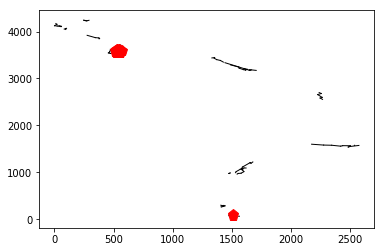

In [11]:
home_loc = plot_observed(data,r=5,w=5,min_pause=30)

## 6. Code for imputation

In [12]:
def select_traj(data,r,w,min_pause,sigma2,tol,d):
  txy = xytransform(data)
  new_txy = gps_smoothing(txy['t'],txy['x'],txy['y'],txy['hour'])
  traj = rectangle(new_txy['t'],new_txy['x'],new_txy['y'],r,w,min_pause)
  X = np.transpose(np.vstack([new_txy['t'],new_txy['x']]))
  Y = new_txy['y']
  result1 = SOGP(X,Y,sigma2,tol,d)['bv']
  X = np.transpose(np.vstack([new_txy['t'],new_txy['y']]))
  Y = new_txy['x']
  result2 = SOGP(X,Y,sigma2,tol,d)['bv']
  index = np.unique(np.append(result1,result2))
  selected_time = new_txy['t'][index]
  m = np.shape(traj)[0]
  selected_index = np.array([],dtype=int)
  for i in range(m):
    if any(np.array(selected_time - traj[i,0]>=0)*np.array(traj[i,1] - selected_time>=0)==True):
      selected_index = np.append(selected_index,i)
  selected_traj = traj[selected_index,:]
  return {'original':traj, 'selected':selected_traj,'bv_index':index}

In [13]:
def create_tables(traj, selected_traj):
  n = np.shape(traj)[0]
  m = np.shape(selected_traj)[0]
  index = [selected_traj[i,6]==1 for i in range(m)]
  flight_table = selected_traj[index,:]
  index = [selected_traj[i,6]==0 for i in range(m)]
  pause_table = selected_traj[index,:]
  mis_table = np.zeros(6)
  for i in range(n-1):
    if traj[i+1,0]!=traj[i,1]:
      mov = np.array([traj[i,1],traj[i+1,0],traj[i,3],traj[i+1,2],traj[i,5],traj[i+1,4]])
      mis_table = np.vstack((mis_table,mov))
  mis_table = np.delete(mis_table,0,0)
  return {'flight':flight_table,'pause':pause_table,'mis':mis_table}

In [14]:
def impute_trajectory(method,traj_dict):
  radius=50
  selected_traj = traj_dict['selected']
  traj = traj_dict['original']
  tables = create_tables(traj, selected_traj)
  flight_table = tables['flight']
  pause_table = tables['pause']
  mis_table = tables['mis']
  distortions = []
  mat = pause_table[:,[2,4]]
  for k in range(1,10):
    kmeanModel = KMeans(n_clusters=k).fit(mat)
    kmeanModel.fit(mat)
    distortions.append(sum(np.min(cdist(mat, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / mat.shape[0])
  vec = np.array(distortions[:-1])-np.array(distortions[1:])
  num = [i for i, x in enumerate(vec) if x<30][0]+1  ## 30 here is very arbitary
  kmeans = KMeans(n_clusters=num)
  kmeans = kmeans.fit(mat)
  centroids = kmeans.cluster_centers_
  mis_start = mis_table[:,0];mis_end = mis_table[:,1]
  mis_x0 = mis_table[:,2];mis_x1 = mis_table[:,3]
  mis_y0 = mis_table[:,4];mis_y1 = mis_table[:,5]
  t_list_pause=(pause_table[:,0]+pause_table[:,1])/2
  x_list_pause=(pause_table[:,2]+pause_table[:,3])/2
  y_list_pause=(pause_table[:,4]+pause_table[:,5])/2
  t_list_flight=(flight_table[:,0]+flight_table[:,1])/2
  x_list_flight=(flight_table[:,2]+flight_table[:,3])/2
  y_list_flight=(flight_table[:,4]+flight_table[:,5])/2
  imp_start=np.array([]);imp_end=np.array([])
  imp_t=np.array([]);imp_s=np.array([])
  imp_x0=np.array([]);imp_x1=np.array([])
  imp_y0=np.array([]);imp_y1=np.array([])
  t_list_m=(selected_traj[:,0]+selected_traj[:,1])/2
  x_list_m=(selected_traj[:,2]+selected_traj[:,3])/2
  y_list_m=(selected_traj[:,4]+selected_traj[:,5])/2
  obs_start = selected_traj[:,0]; obs_end = selected_traj[:,1]
  obs_x0 = selected_traj[:,2]; obs_x1 = selected_traj[:,3]
  obs_y0 = selected_traj[:,4]; obs_y1 = selected_traj[:,5]
  a1 = 10; b1 = 10; a2 = 70; b2 = 70; g = 200
  def K1(method_,current_t_,current_x_,current_y_,t_list=[],x_list=[],y_list=[]):
    if method_=="TL":
      return np.exp(-abs(t_list-current_t_)/86400/b1)
    if method_=="GL":
      d = np.sqrt((current_x_-x_list)**2+(current_y_-y_list)**2)
      return np.exp(-d/g)
    if method_=="GLC":
      k1 = np.exp(-(abs(t_list-current_t_)%86400)/a1)*np.exp(-np.floor(abs(t_list-current_t_)/86400)/b1)
      k2 = np.exp(-(abs(t_list-current_t_)%604800)/a2)*np.exp(-np.floor(abs(t_list-current_t_)/604800)/b2)
      d = np.sqrt((current_x_-x_list)**2+(current_y_-y_list)**2)
      k3 = np.exp(-d/g)
      return 0.35*k1+0.15*k2+0.5*k3

  def I_flight(method_,centroids_,current_t_,current_x_,current_y_,dest_t,dest_x,dest_y):
    K_ = K1(method_,current_t_,current_x_,current_y_,t_list_m,x_list_m,y_list_m)
    temp1 = K_[selected_traj[:,6]==1]
    temp0 = K_[selected_traj[:,6]==0]
    temp1[::-1].sort()
    temp0[::-1].sort()
    w1 = np.mean(temp1[:10])
    w0 = np.mean(temp0[:10])
    p = w1/(w1+w0)
    d_dest = np.sqrt((dest_x-current_x_)**2+(dest_y-current_y_)**2)
    v_dest = d_dest/(dest_t-current_t_+0.0001)
    s1 = int(d_dest<3000)*int(v_dest>1.5)
    s2 = int(d_dest>=3000)*int(v_dest>14)
    s3 = np.sqrt((centroids_[:,0]-current_x_)**2+(centroids_[:,1]-current_y_)**2)<radius
    s4 = np.sqrt((centroids_[:,0]-dest_x)**2+(centroids_[:,1]-dest_y)**2)<radius
    if s1+s2==0 and sum(s3)==0 and sum(s4)==0:
      out = stat.bernoulli.rvs(p,size=1)[0]
    elif s1+s2==0 and sum(s3)==1 and sum(s4)==0:
      out = stat.bernoulli.rvs(max(0,p-0.4),size=1)[0]
    elif s1+s2==0 and sum(s3)==0 and sum(s4)==1:
      out = stat.bernoulli.rvs(min(1,p+0.4),size=1)[0]
    elif s1+s2==0 and sum(s3)==1 and sum(s4)==1 and sum(s3==s4)==len(s3):
      out = stat.bernoulli.rvs(max(0,p-0.6),size=1)[0]
    elif s1+s2==0 and sum(s3)==1 and sum(s4)==1 and sum(s3==s4)!=len(s3):
      out = stat.bernoulli.rvs(max(0,p-0.2),size=1)[0]
    elif d_dest<radius:
      out = stat.bernoulli.rvs(max(0,p-0.6),size=1)[0]
    elif s1+s2>0:
      out = 1
    else:
      out = stat.bernoulli.rvs(p,size=1)[0]
    return out
  
  for i in range(mis_table.shape[0]):
    current_t=mis_start[i]
    current_x=mis_x0[i]
    current_y=mis_y0[i]
    vec_x=[];vec_y=[]   ## record delta x,y
    while current_t < mis_end[i]:
      I = I_flight(method,centroids,current_t,current_x,current_y,mis_end[i],mis_x1[i],mis_y1[i])
      if I==1:
        ## change this function
        d2all = np.sqrt((current_x-x_list_m)**2+(current_y-y_list_m)**2)>200
        abnormal = int(sum(d2all)==len(x_list_m))
        weight= K1("GLC",current_t,current_x,current_y,t_list_flight,x_list_flight,t_list_flight)
        normalize_w=weight/sum(weight)
        flight_index=np.random.choice(flight_table.shape[0], p=normalize_w)
        delta_t=(flight_table[flight_index,1]-flight_table[flight_index,0])
        delta_x=(flight_table[flight_index,3]-flight_table[flight_index,2])
        delta_y=(flight_table[flight_index,5]-flight_table[flight_index,4])
        d_imp = np.sqrt(delta_x**2+delta_y**2)
        d_act = np.sqrt((mis_x0[i]-mis_x1[i])**2+(mis_y0[i]-mis_y1[i])**2)
        ratio = d_act/(d_imp+0.0001)
        mov1 = np.array([mis_x1[i]-current_x,mis_y1[i]-current_y])
        mov2 = np.array([delta_x,delta_y])
        inner_prod = mov1.dot(mov2)
        u = stat.bernoulli.rvs(normalize_w[flight_index],size=1)[0]
        if (inner_prod<0 and u==0) or abnormal==1:  
          delta_x = 0.5*(mis_x1[i]-current_x)/(np.linalg.norm(mis_x1[i]-current_x)+0.0001)*np.linalg.norm(delta_x)-0.5*delta_x
          delta_y = 0.5*(mis_y1[i]-current_y)/(np.linalg.norm(mis_y1[i]-current_y)+0.0001)*np.linalg.norm(delta_y)-0.5*delta_y
        if ratio<=1:
          delta_t = 0.8*delta_t*ratio
          delta_x = 0.8*(delta_x*ratio+mis_x1[i]-current_x)/2
          delta_y = 0.8*(delta_y*ratio+mis_y1[i]-current_y)/2
        if(current_t+delta_t>=mis_end[i]):
          temp=delta_t
          delta_t=mis_end[i]-current_t
          delta_x=delta_x*delta_t/temp
          delta_y=delta_y*delta_t/temp
        vec_x.append(delta_x)
        vec_y.append(delta_y)
        imp_start = np.append(imp_start,current_t)
        current_t=current_t+delta_t
        imp_end = np.append(imp_end,current_t)
        imp_t = np.append(imp_t,delta_t)
        imp_s = np.append(imp_s,1)
        imp_x0 = np.append(imp_x0,current_x)
        current_x=(mis_end[i]-current_t)/(mis_end[i]-mis_start[i])*(mis_x0[i]+sum(vec_x))+(current_t-mis_start[i])/(mis_end[i]-mis_start[i])*mis_x1[i]
        imp_x1 = np.append(imp_x1,current_x)
        imp_y0 = np.append(imp_y0,current_y)
        current_y=(mis_end[i]-current_t)/(mis_end[i]-mis_start[i])*(mis_y0[i]+sum(vec_y))+(current_t-mis_start[i])/(mis_end[i]-mis_start[i])*mis_y1[i]
        imp_y1 = np.append(imp_y1,current_y)
      if I==0:
        weight= K1("GLC",current_t,current_x,current_y,t_list_pause,x_list_pause,t_list_pause)
        normalize_w=weight/sum(weight)
        pause_index=np.random.choice(pause_table.shape[0], p=normalize_w)
        R = np.random.uniform(1,5,size=1)[0]
        delta_x=0
        delta_y=0
        s = 0
        delta_t=(pause_table[pause_index,1]-pause_table[pause_index,0])*R
        if(current_t+delta_t>=mis_end[i]):
          delta_t=mis_end[i]-current_t
          delta_x=mis_x1[i]-current_x
          delta_y=mis_y1[i]-current_y
        if delta_x**2+delta_y**2>100:
          s = 1
        vec_x.append(delta_x)
        vec_y.append(delta_y)
        imp_start = np.append(imp_start,current_t)
        current_t=current_t+delta_t
        imp_end = np.append(imp_end,current_t)
        imp_t = np.append(imp_t,delta_t)
        imp_s = np.append(imp_s,s)
        imp_x0 = np.append(imp_x0,current_x)
        current_x = current_x + delta_x
        imp_x1 = np.append(imp_x1,current_x)
        imp_y0 = np.append(imp_y0,current_y)
        current_y = current_y + delta_y
        imp_y1 = np.append(imp_y1,current_y)     
  imp_table=np.stack([imp_start,imp_end,imp_x0,imp_x1,imp_y0,imp_y1,imp_s], axis=1)
  return imp_table

## 7. Apply the method on the data

In [15]:
r=5;w=5;min_pause=30;sigma2=2;tol=0.05;d=200
traj_dict = select_traj(data,r,w,min_pause,sigma2,tol,d)
imp_table = impute_trajectory('GLC',traj_dict)
np.shape(imp_table)[0]

1193

In [20]:
np.savetxt('imp_table_compare.txt', imp_table)
np.savetxt('orig_table_compare.txt', traj_dict['original'])

In [21]:
imp_table = np.loadtxt('imp_table_compare.txt')
orig_table = np.loadtxt('orig_table_compare.txt')
imp_table

array([[ 8.10380000e+01,  2.93515973e+02,  5.42735989e+02,
         5.42735989e+02,  3.59498049e+03,  3.59498049e+03,
         0.00000000e+00],
       [ 2.93515973e+02,  6.03406662e+02,  5.42735989e+02,
         5.42735989e+02,  3.59498049e+03,  3.59498049e+03,
         0.00000000e+00],
       [ 6.03406662e+02,  8.99077000e+02,  5.42735989e+02,
         5.68131920e+02,  3.59498049e+03,  3.61009917e+03,
         1.00000000e+00],
       [ 9.95038000e+02,  1.34509746e+03,  5.53242066e+02,
         5.53242066e+02,  3.59767073e+03,  3.59767073e+03,
         0.00000000e+00],
       [ 1.34509746e+03,  1.64239684e+03,  5.53242066e+02,
         5.53242066e+02,  3.59767073e+03,  3.59767073e+03,
         0.00000000e+00],
       [ 1.64239684e+03,  1.79813200e+03,  5.53242066e+02,
         5.78643219e+02,  3.59767073e+03,  3.59824046e+03,
         1.00000000e+00],
       [ 1.89503700e+03,  2.22518485e+03,  5.73873319e+02,
         5.73873319e+02,  3.59078006e+03,  3.59078006e+03,
         0.0000000

In [74]:
def xy_w_newt(data):
  time_temp = [datetime.strptime(i, '%m/%d/%Y %H:%M') for i in data['time']]
  timestamp = [time.mktime(i.timetuple()) for i in time_temp]
  start = 0
  count = 0
  for i in range(len(timestamp)-1):
    if timestamp[i+1]-timestamp[start]==0:
      count = count + 1
    if timestamp[i+1]-timestamp[start]>0 and count>0:
      for j in range(count):
        timestamp[i-j] = timestamp[start]+60/(count+1)*(count-j)
      count = 0
      start = i+1
    if timestamp[i+1]-timestamp[start]>0 and count==0:
      start = i+1
  latitude = np.array(data["latitude"])/180*math.pi
  longitude = np.array(data["longitude"])/180*math.pi
  lam_min=min(latitude)
  lam_max=max(latitude)
  phi_min=min(longitude)
  phi_max=max(longitude)
  R=6.371*10**6
  d1=(lam_max-lam_min)*R
  d2=(phi_max-phi_min)*R*math.sin(math.pi/2-lam_max)
  d3=(phi_max-phi_min)*R*math.sin(math.pi/2-lam_min)
  w1=(latitude-lam_min)/(lam_max-lam_min)
  w2=(longitude-phi_min)/(phi_max-phi_min)
  x=np.array(w1*(d3-d2)/2+w2*(d3*(1-w1)+d2*w1))
  y=np.array(w1*d1*math.sin(math.acos((d3-d2)/(2*d1))))
  return {'t':timestamp,'x':x,'y':y}

In [75]:
## plot 04-09/04-10
breakpoint = (1554782400000.0 + 24*60*60*1000-min(data["timestamp"]))/1000
imp_09 = imp_table[imp_table[:,1]<=breakpoint,:]
imp_10 = imp_table[imp_table[:,1]>breakpoint,:]
true09 = xy_w_newt(pd.read_csv('C:/Users/glius/Google Drive/Gaussian Process/gps-primetracker/2019-04-09.csv'))
true10 = xy_w_newt(pd.read_csv('C:/Users/glius/Google Drive/Gaussian Process/gps-primetracker/2019-04-10.csv'))

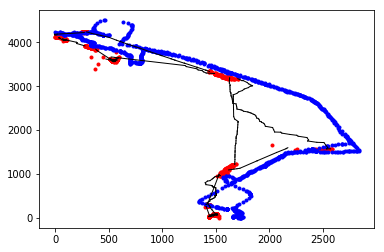

In [24]:
plt.plot(txy['x'][txy['t']<=breakpoint],txy['y'][txy['t']<=breakpoint],'r.')
plt.plot(true09['x'],true09['y'],'b.')
for i in range(np.shape(imp_09)[0]):
  plt.plot([imp_09[i,2], imp_09[i,3]], [imp_09[i,4], imp_09[i,5]], 'k-', lw=1)
plt.show()

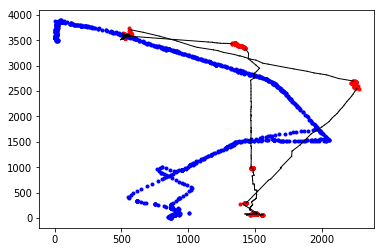

In [25]:
plt.plot(txy['x'][txy['t']>breakpoint],txy['y'][txy['t']>breakpoint],'r.')
plt.plot(true10['x'],true10['y'],'b.')
for i in range(np.shape(imp_10)[0]):
  plt.plot([imp_10[i,2], imp_10[i,3]], [imp_10[i,4], imp_10[i,5]], 'k-', lw=1)
plt.show()

## 8. Create daily summary statistics

In [113]:
a1 = datetime.strptime(np.array(data['UTC time'])[0], '%Y-%m-%dT%H:%M:%S.%f')
b1 = a1 - timedelta(hours=4)  ### +timedelta(days=1) for general use, but in this case, don't need this
c1 = datetime(b1.year,b1.month,b1.day,0,0)
g1 = time.mktime(c1.timetuple())
f1 = datetime.utcfromtimestamp(g1) - timedelta(hours=4)
a2 = datetime.strptime(np.array(data['UTC time'])[-1], '%Y-%m-%dT%H:%M:%S.%f')
b2 = a2 + timedelta(hours=4) ### -timedelta(days=1)
c2 = datetime(b2.year,b2.month,b2.day,0,0)
g2 = time.mktime(c2.timetuple())
f2 = datetime.utcfromtimestamp(g2) - timedelta(hours=4)
f1,f1.strftime('%Y-%m-%d'),f2,f2.strftime('%Y-%m-%d')

(datetime.datetime(2019, 4, 9, 0, 0),
 '2019-04-09',
 datetime.datetime(2019, 4, 11, 0, 0),
 '2019-04-11')

In [34]:
num_days = int((g2-g1)/24/60/60/1000)
summary_stats = pd.DataFrame(columns=['date', 'duration_home', 'pause_time','missing_time','dist_traveled','mean_f_len','sd_f_len',
                                     'mean_f_time','sd_f_time','radius','max_dist_from_home','max_diameter',
                                     'num_sig_loc','loc_entropy'])
for j in range(num_days):
  T = g1 + j*24*60*60*1000
  sub_index = (imp_table[:,0]*1000+min(data["timestamp"])>=T)*(imp_table[:,1]*1000+min(data["timestamp"])<T+24*60*60*1000)
  sub_index_orig = (orig_table[:,0]*1000+min(data["timestamp"])>=T)*(orig_table[:,1]*1000+min(data["timestamp"])<T+24*60*60*1000)
  # add a row on the top and a row to the bottom (fill in tiny gaps between 0 and the true starting point, also the 
  # between 24 and the true ending point)
  sub_data = imp_table[sub_index,:]
  sub_data_orig = orig_table[sub_index_orig,:]
  missing_t = 24-sum(sub_data_orig[:,1]-sub_data_orig[:,0])/60/60
  bottom = [sub_data[-1,1],(T+24*60*60*1000-min(data["timestamp"]))/1000,sub_data[-1,3],sub_data[-1,3],
            sub_data[-1,5],sub_data[-1,5],0]
  top = [(T-min(data["timestamp"]))/1000,sub_data[0,0],sub_data[-1,2],sub_data[-1,2],
            sub_data[-1,4],sub_data[-1,4],0]
  sub_data = np.vstack((top,sub_data,bottom))
  pause_set = sub_data[sub_data[:,6]==0,:]
  flight_set = sub_data[sub_data[:,6]==1,:]
  duration = 0
  for i in range(sub_data.shape[0]):
    d1 = np.sqrt((home_loc[0]-sub_data[i,2])**2+(home_loc[1]-sub_data[i,4])**2)
    d2 = np.sqrt((home_loc[0]-sub_data[i,3])**2+(home_loc[1]-sub_data[i,5])**2)
    if d1<100 and d2<100:
      duration = duration + sub_data[i,1] - sub_data[i,0]
  
  pause_time = sum(pause_set[:,1]-pause_set[:,0])
  dist = 0
  d_vec = []
  t_vec = []
  for i in range(flight_set.shape[0]):
    d = np.sqrt((flight_set[i,2]-flight_set[i,3])**2+(flight_set[i,4]-flight_set[i,5])**2)
    d_vec.append(d)
    t_vec.append(flight_set[i,1]-flight_set[i,0])
    dist = dist + d
  
  centroid_x = 0
  centroid_y = 0
  radius = 0 
  for i in range(sub_data.shape[0]):
    centroid_x = centroid_x + (sub_data[i,1]-sub_data[i,0])/(24*60*60)*sub_data[i,2]
    centroid_y = centroid_y + (sub_data[i,1]-sub_data[i,0])/(24*60*60)*sub_data[i,4]

  for i in range(sub_data.shape[0]):
    d = np.sqrt((sub_data[i,2]-centroid_x)**2+(sub_data[i,4]-centroid_y)**2)
    radius = radius + (sub_data[i,1]-sub_data[i,0])/(24*60*60)*d 
    
  dist_from_home = []
  for i in range(sub_data.shape[0]):
    d = np.sqrt((sub_data[i,2]-home_loc[0])**2+(sub_data[i,4]-home_loc[1])**2)
    dist_from_home.append(d) 

  D = pdist(sub_data[:,[2,4]])
  D = squareform(D)
  N, [I_row, I_col] = nanmax(D), unravel_index( argmax(D), D.shape)
  
  distortions = []
  mat = pause_set[:,[2,4]]
  for k in range(1,10):
    kmeanModel = KMeans(n_clusters=k).fit(mat)
    kmeanModel.fit(mat)
    distortions.append(sum(np.min(cdist(mat, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / mat.shape[0])
  vec = np.array(distortions[:-1])-np.array(distortions[1:])
  num = [i for i, x in enumerate(vec) if x<30][0]+1  ## 30 here is very arbitary
  kmeans = KMeans(n_clusters=num)
  kmeans = kmeans.fit(mat)
  centroids = kmeans.cluster_centers_
  n_centroid = centroids.shape[0]
  t_at_centroid = np.zeros(n_centroid) 
  for i in range(pause_set.shape[0]):
    for j in range(n_centroid):
      d = np.sqrt((pause_set[i,2]-centroids[j,0])**2+(pause_set[i,4]-centroids[j,1])**2)
      if d < 100:
        t_at_centroid[j] = t_at_centroid[j] + pause_set[i,1] - pause_set[i,0]
  p = t_at_centroid/sum(t_at_centroid)
  entropy = -sum(p*np.log(p+0.00001))
  f = datetime.utcfromtimestamp(T/1000) - timedelta(hours=4)
  new_line = [f.strftime('%Y-%m-%d'),duration/60/60,pause_time/60/60,missing_t,dist,np.mean(d_vec),
            np.std(d_vec),np.mean(t_vec),np.std(t_vec),radius,max(dist_from_home), N,n_centroid,entropy]
  summary_stats.loc[-1] = new_line
  summary_stats.index = summary_stats.index + 1  # shifting index
  summary_stats = summary_stats.sort_index()  

In [35]:
summary_stats

,date,duration_home,pause_time,missing_time,dist_traveled,mean_f_len,sd_f_len,mean_f_time,sd_f_time,radius,max_dist_from_home,max_diameter,num_sig_loc,loc_entropy
0,2019-04-10,14.550790,17.235843,19.654338,10232.323334,41.594810,59.341985,47.769215,80.447242,1351.899832,3678.722565,3712.325968,2,0.598536
1,2019-04-09,11.645954,17.607131,20.607983,12069.506365,33.249329,55.784691,33.130513,62.139266,1517.944759,3672.232955,4396.854032,3,0.784280


In [106]:
## compare with groundtruth
r=20;w=20;min_pause=30
orig09=rectangle(true09['t'],true09['x'],true09['y'],r,w,min_pause)
orig10=rectangle(true10['t'],true10['x'],true10['y'],r,w,min_pause)

In [107]:
## check if orig09 is complete
count = 0
comp = []
n = orig09.shape[0]
for i in range(n-1):
  if orig09[i+1,0]!=orig09[i,1]:
    count = count + 1
    d = np.sqrt((orig09[i,3]-orig09[i+1,2])**2+(orig09[i,5]-orig09[i+1,4])**2)
    if d > 20:
      comp.append([orig09[i,1],orig09[i+1,0],orig09[i,3],orig09[i+1,2],orig09[i,5],orig09[i+1,4],1])
    if d <=20:
      comp.append([orig09[i,1],orig09[i+1,0],orig09[i,3],orig09[i+1,2],orig09[i,5],orig09[i+1,4],0])
t1 = time.mktime(datetime(2019, 4, 9, 0, 0).timetuple())
t2 = time.mktime(datetime(2019, 4, 10, 0, 0).timetuple())
comp.append([t1,orig09[0,0],orig09[0,3],orig09[0,2],orig09[0,5],orig09[0,4],0])
comp.append([orig09[n-1,1],t2,orig09[n-1,3],orig09[n-1,2],orig09[n-1,5],orig09[n-1,4],0])  


n = orig10.shape[0]
for i in range(n-1):
  if orig10[i+1,0]!=orig10[i,1]:
    count = count + 1
    d = np.sqrt((orig10[i,3]-orig10[i+1,2])**2+(orig10[i,5]-orig10[i+1,4])**2)
    if d > 20:
      comp.append([orig10[i,1],orig10[i+1,0],orig10[i,3],orig10[i+1,2],orig10[i,5],orig10[i+1,4],1])
    if d <=20:
      comp.append([orig10[i,1],orig10[i+1,0],orig10[i,3],orig10[i+1,2],orig10[i,5],orig10[i+1,4],0])
t1 = time.mktime(datetime(2019, 4, 10, 0, 0).timetuple())
t2 = time.mktime(datetime(2019, 4, 11, 0, 0).timetuple())
comp.append([t1,orig10[0,0],orig10[0,3],orig10[0,2],orig10[0,5],orig10[0,4],0])
comp.append([orig10[n-1,1],t2,orig10[n-1,3],orig10[n-1,2],orig10[n-1,5],orig10[n-1,4],0])  
comp = np.array(comp)

In [108]:
complete = np.vstack((orig09,orig10,comp))
complete.shape

(462, 7)

In [125]:
num_days = 2
summary_stats = pd.DataFrame(columns=['date', 'duration_home', 'pause_time','missing_time','dist_traveled','mean_f_len','sd_f_len',
                                     'mean_f_time','sd_f_time','radius','max_dist_from_home','max_diameter',
                                     'num_sig_loc','loc_entropy'])
for j in range(num_days):
  if j==0: 
    home_loc = [orig09[0,2],orig09[0,4]]
  if j==1:
    home_loc = [orig10[0,2],orig10[0,4]]
  T = g1 + j*24*60*60
  sub_index = (complete[:,0]>=T)*(complete[:,1]<T+24*60*60)
  sub_data = complete[sub_index,:]
  pause_set = sub_data[sub_data[:,6]==0,:]
  flight_set = sub_data[sub_data[:,6]==1,:]
  duration = 0
  for i in range(sub_data.shape[0]):
    d1 = np.sqrt((home_loc[0]-sub_data[i,2])**2+(home_loc[1]-sub_data[i,4])**2)
    d2 = np.sqrt((home_loc[0]-sub_data[i,3])**2+(home_loc[1]-sub_data[i,5])**2)
    if d1<100 and d2<100:
      duration = duration + sub_data[i,1] - sub_data[i,0]
  
  pause_time = sum(pause_set[:,1]-pause_set[:,0])
  dist = 0
  d_vec = []
  t_vec = []
  for i in range(flight_set.shape[0]):
    d = np.sqrt((flight_set[i,2]-flight_set[i,3])**2+(flight_set[i,4]-flight_set[i,5])**2)
    d_vec.append(d)
    t_vec.append(flight_set[i,1]-flight_set[i,0])
    dist = dist + d
  
  centroid_x = 0
  centroid_y = 0
  radius = 0 
  for i in range(sub_data.shape[0]):
    centroid_x = centroid_x + (sub_data[i,1]-sub_data[i,0])/(24*60*60)*sub_data[i,2]
    centroid_y = centroid_y + (sub_data[i,1]-sub_data[i,0])/(24*60*60)*sub_data[i,4]

  for i in range(sub_data.shape[0]):
    d = np.sqrt((sub_data[i,2]-centroid_x)**2+(sub_data[i,4]-centroid_y)**2)
    radius = radius + (sub_data[i,1]-sub_data[i,0])/(24*60*60)*d 
    
  dist_from_home = []
  for i in range(sub_data.shape[0]):
    d = np.sqrt((sub_data[i,2]-home_loc[0])**2+(sub_data[i,4]-home_loc[1])**2)
    dist_from_home.append(d) 

  D = pdist(sub_data[:,[2,4]])
  D = squareform(D)
  N, [I_row, I_col] = nanmax(D), unravel_index( argmax(D), D.shape)
  
  distortions = []
  mat = pause_set[:,[2,4]]
  for k in range(1,10):
    kmeanModel = KMeans(n_clusters=k).fit(mat)
    kmeanModel.fit(mat)
    distortions.append(sum(np.min(cdist(mat, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / mat.shape[0])
  vec = np.array(distortions[:-1])-np.array(distortions[1:])
  num = [i for i, x in enumerate(vec) if x<30][0]+1  ## 30 here is very arbitary
  kmeans = KMeans(n_clusters=num)
  kmeans = kmeans.fit(mat)
  centroids = kmeans.cluster_centers_
  n_centroid = centroids.shape[0]
  t_at_centroid = np.zeros(n_centroid) 
  for i in range(pause_set.shape[0]):
    for j in range(n_centroid):
      d = np.sqrt((pause_set[i,2]-centroids[j,0])**2+(pause_set[i,4]-centroids[j,1])**2)
      if d < 100:
        t_at_centroid[j] = t_at_centroid[j] + pause_set[i,1] - pause_set[i,0]
  p = t_at_centroid/sum(t_at_centroid)
  entropy = -sum(p*np.log(p+0.00001))
  f = datetime.utcfromtimestamp(T) - timedelta(hours=4)
  new_line = [f.strftime('%Y-%m-%d'),duration/60/60,pause_time/60/60,0,dist,np.mean(d_vec),
            np.std(d_vec),np.mean(t_vec),np.std(t_vec),radius,max(dist_from_home), N,n_centroid,entropy]
  summary_stats.loc[-1] = new_line
  summary_stats.index = summary_stats.index + 1  # shifting index
  summary_stats = summary_stats.sort_index()  

In [126]:
summary_stats

,date,duration_home,pause_time,missing_time,dist_traveled,mean_f_len,sd_f_len,mean_f_time,sd_f_time,radius,max_dist_from_home,max_diameter,num_sig_loc,loc_entropy
0,2019-04-10,14.733333,14.833684,0,12491.050790,186.433594,212.659182,364.458745,2453.163777,1423.552465,3641.896642,3971.496230,7,0.065963
1,2019-04-09,13.218056,13.683721,0,15406.951576,152.544075,163.402148,367.114911,2650.673161,1666.432864,3652.333236,4675.310017,5,0.107157
